<a href="https://colab.research.google.com/github/HardikDk121/Brain-Tumor-Classification/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow matplotlib kagglehub --quiet

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
save_path = '/content/gdrive/MyDrive/my_models'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow recognized the following GPU(s): {gpus}")
    print("NVIDIA CUDA is likely available and configured for TensorFlow.")
else:
    print("No GPU devices found by TensorFlow. Running on CPU.")

TensorFlow recognized the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
NVIDIA CUDA is likely available and configured for TensorFlow.


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brisc2025' dataset.
Path to dataset files: /kaggle/input/brisc2025


In [7]:
!find /kaggle/input/brisc2025 -maxdepth 3

/kaggle/input/brisc2025
/kaggle/input/brisc2025/brisc2025
/kaggle/input/brisc2025/brisc2025/manifest.json
/kaggle/input/brisc2025/brisc2025/README.md
/kaggle/input/brisc2025/brisc2025/segmentation_task
/kaggle/input/brisc2025/brisc2025/segmentation_task/test
/kaggle/input/brisc2025/brisc2025/segmentation_task/train
/kaggle/input/brisc2025/brisc2025/classification_task
/kaggle/input/brisc2025/brisc2025/classification_task/test
/kaggle/input/brisc2025/brisc2025/classification_task/train
/kaggle/input/brisc2025/brisc2025/manifest.csv
/kaggle/input/brisc2025/brisc2025/manifest.json.sha256
/kaggle/input/brisc2025/brisc2025/manifest.csv.sha256


In [8]:

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Define dataset paths and image parameters
# Structure should be:
#   Train/ -> [tumor, notumor]
#   Test/  -> [tumor, notumor]
TRAIN_DIR = '/kaggle/input/brisc2025/brisc2025/classification_task/train'
TEST_DIR = '/kaggle/input/brisc2025/brisc2025/classification_task/test'
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001 # Slower learning rate for better stability

After mounting, you can save your model to a specific folder in your Google Drive, for example, to a folder named `my_models`:

### 2. Data Preprocessing & Augmentation

In [9]:
# --- 1. LOAD THE RAW DATA ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False  
)

# --- 2. MAP TO BINARY ---
def map_to_binary(image, label):
    # Assumes 'no_tumor' is folder index 2
    binary_label = tf.where(label == 2, 0, 1)
    return image, binary_label

AUTOTUNE = tf.data.AUTOTUNE

# Apply the binary mapping and optimize performance
train_loader = train_dataset.map(map_to_binary, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
test_loader = test_dataset.map(map_to_binary, num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

# --- 3. DEFINE AUGMENTATION AS A MODEL COMPONENT ---
# Instead of mapping this to the dataset, we will put this directly inside your CNN!
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=15.0 / 360.0)
])

Found 5000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


### 3. Build multiclass CNN Architecture

In [14]:
def build_binary_cnn(): # (Renamed slightly for clarity since it's binary!)
    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        
        # ⚠️ ADD YOUR AUGMENTATION AND RESCALING HERE
        data_augmentation, 

        # Block 1: Feature Extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2: Deeper Features
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3: Complex Patterns
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening
        Flatten(),

        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.5), # Regularization to prevent overfitting

        # Output Layer: 1 neuron with 'sigmoid' for Binary Classification
        Dense(1, activation='sigmoid')
    ])

    return model
model = build_binary_cnn()

### 4. Compile Model

In [15]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy', # ⚠️ CRITICAL: Loss function for multiclass tasks
    metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)

# Show architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Train Model

In [16]:
print("\n🚀 Starting Training...")
history = model.fit(
    train_loader,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    validation_data=test_loader,
    validation_steps=len(test_loader),
    verbose=1
)


🚀 Starting Training...
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.7509 - auc: 0.6329 - loss: 0.6551 - val_accuracy: 0.9210 - val_auc: 0.9594 - val_loss: 0.1739
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.9297 - auc: 0.9742 - loss: 0.1656 - val_accuracy: 0.9480 - val_auc: 0.9817 - val_loss: 0.1281
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9585 - auc: 0.9897 - loss: 0.1141 - val_accuracy: 0.9260 - val_auc: 0.9838 - val_loss: 0.1807
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9669 - auc: 0.9910 - loss: 0.1031 - val_accuracy: 0.9250 - val_auc: 0.9902 - val_loss: 0.1784
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9695 - auc: 0.9914 - loss: 0.0888 - val_accuracy: 0.9450 - val_auc: 0.9898 - val_loss: 0.1250
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9685 - auc: 0.9912 - loss: 0.0967 - val_accuracy: 0.9340 - val_auc: 0.9953 - val_loss: 0.1202
Epoch 7/15


In [17]:
model.save('/content/drive/MyDrive/my_models/multiclass_brain_tumor_detector.keras')
print("\n💾 Model saved to Google Drive: '/content/drive/MyDrive/my_models/multiclass_brain_tumor_detector.keras'")


💾 Model saved to Google Drive: '/content/drive/MyDrive/my_models/multiclass_brain_tumor_detector.keras'


### 6. Evaluation & Saving

In [18]:
print("\n📊 Evaluating Final Performance...")
loss, accuracy, auc = model.evaluate(test_loader, verbose=0)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Final Test Loss: {loss:.4f}")
print(f"✅ Final Test AUC: {auc:.4f}")

# Save the model for future comparison
model.save("final_binary_model.keras")


📊 Evaluating Final Performance...
✅ Final Test Accuracy: 94.20%
✅ Final Test Loss: 0.1100
✅ Final Test AUC: 0.9939


### 7. Visualization

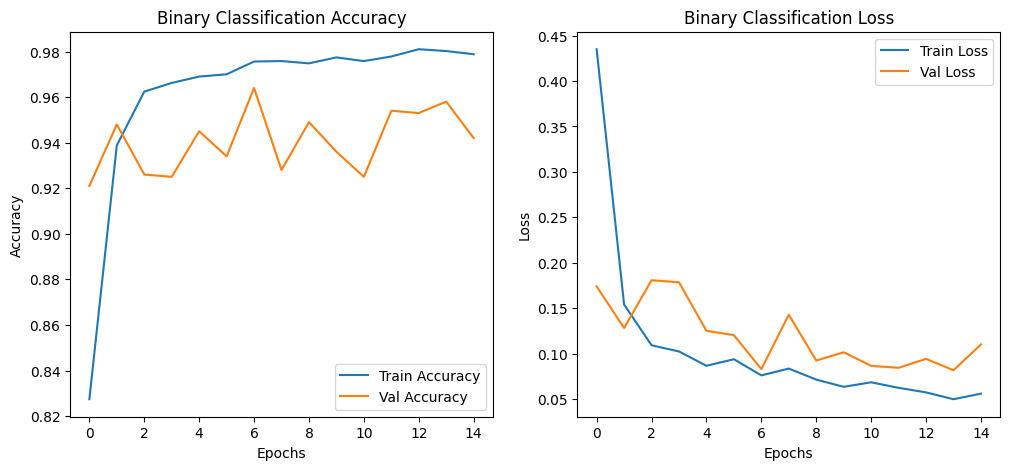

In [20]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Binary Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Binary Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()